In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, cohen_kappa_score
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("/Users/strou/OneDrive - LUT University/GitHub/train.csv")
test = pd.read_csv("/Users/strou/OneDrive - LUT University/GitHub/test.csv")

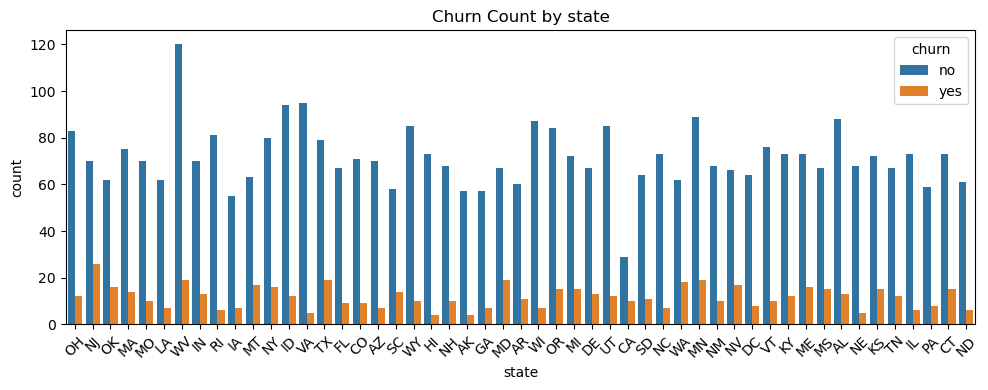

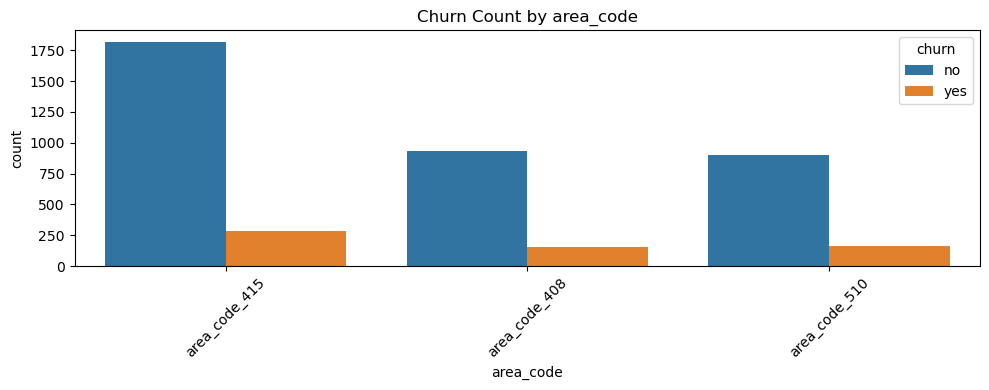

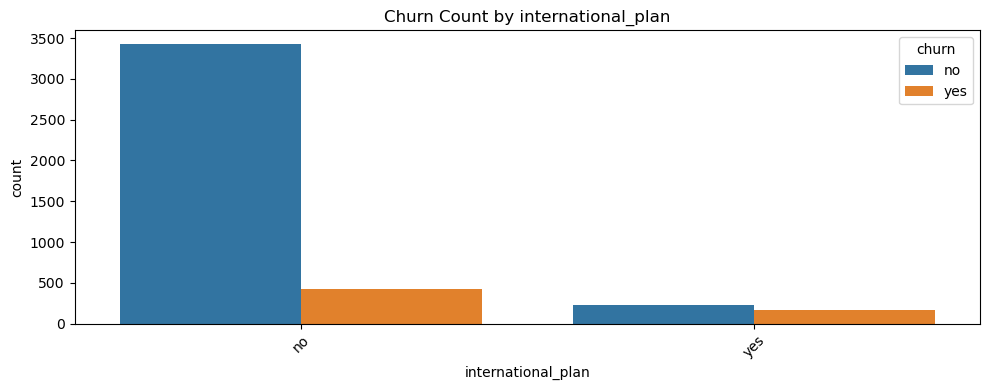

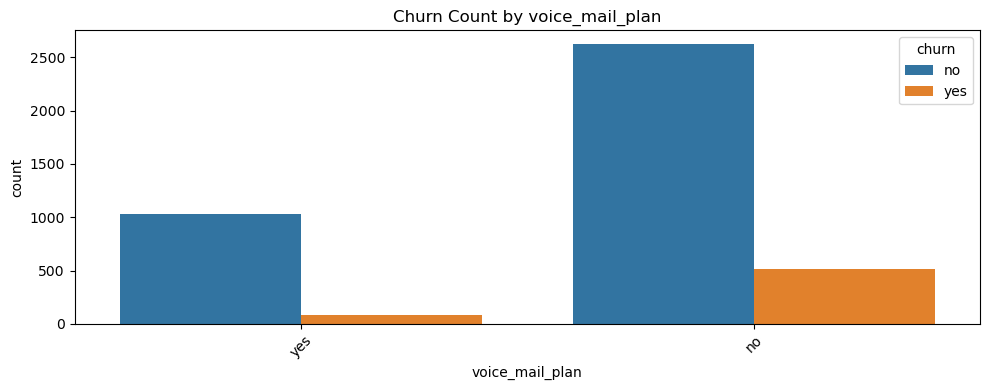

In [3]:

categorical_vars = ['state', 'area_code', 'international_plan', 'voice_mail_plan']

for var in categorical_vars:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=var, hue='churn', data=train)
    plt.title(f'Churn Count by {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


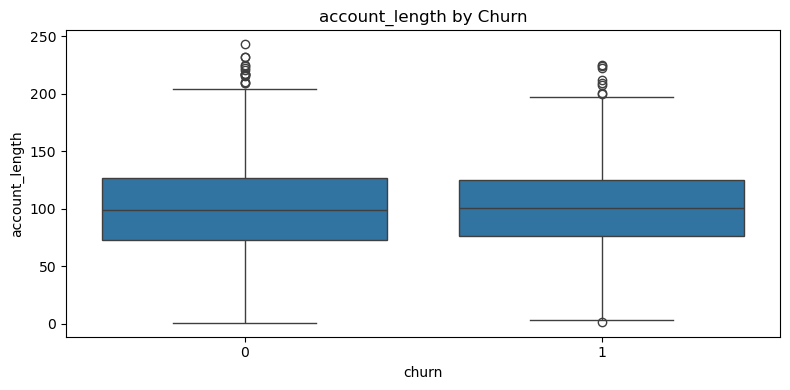

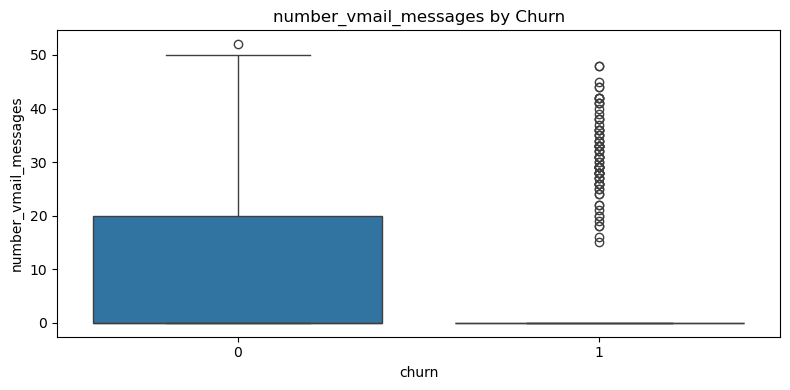

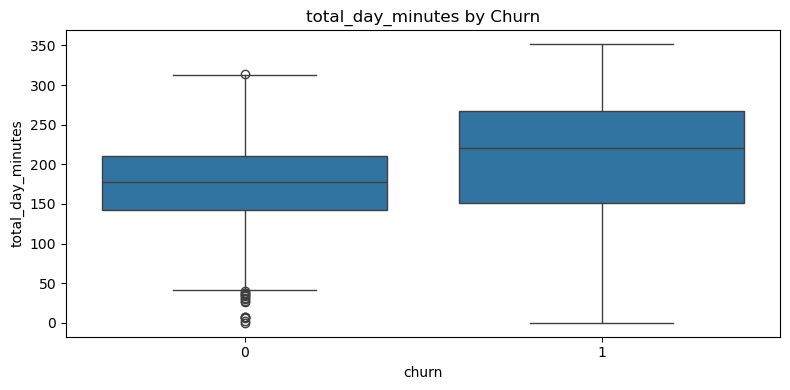

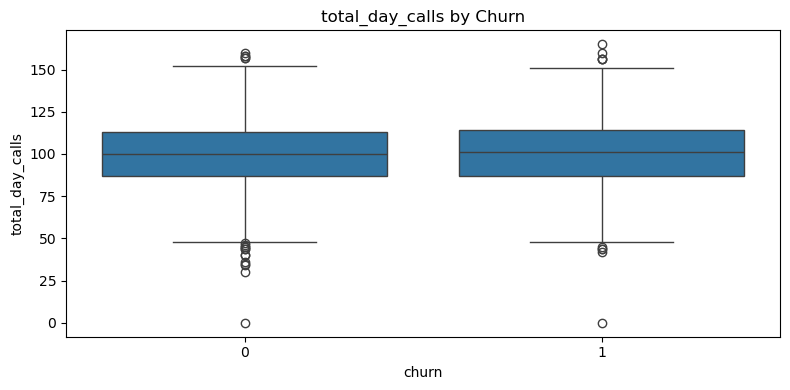

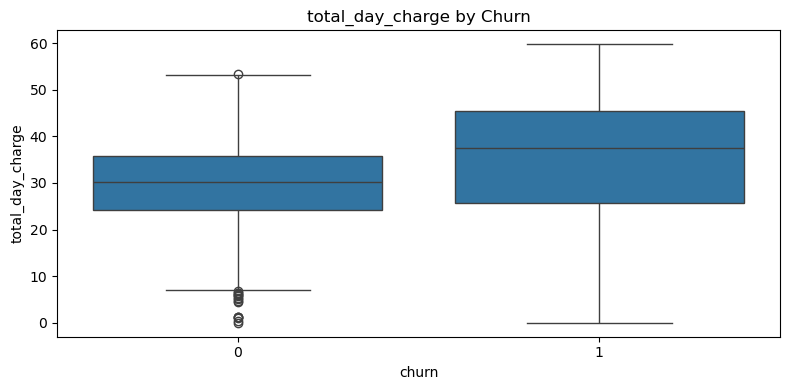

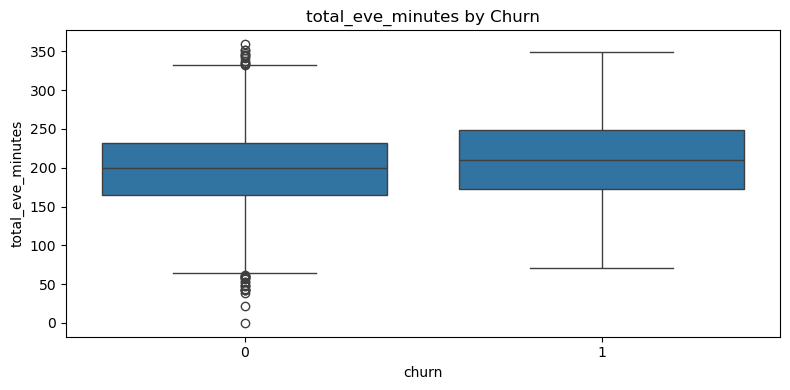

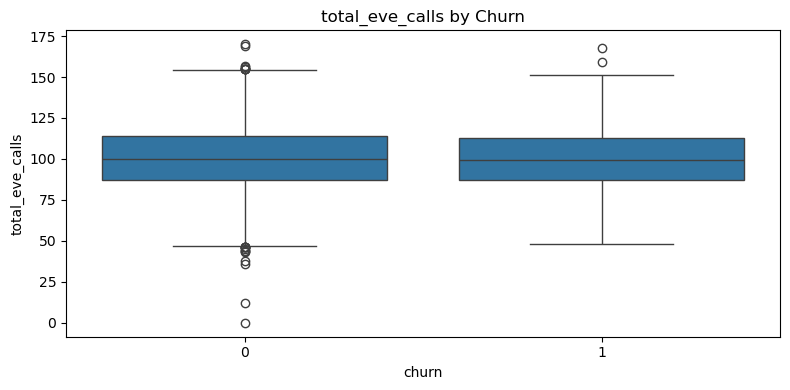

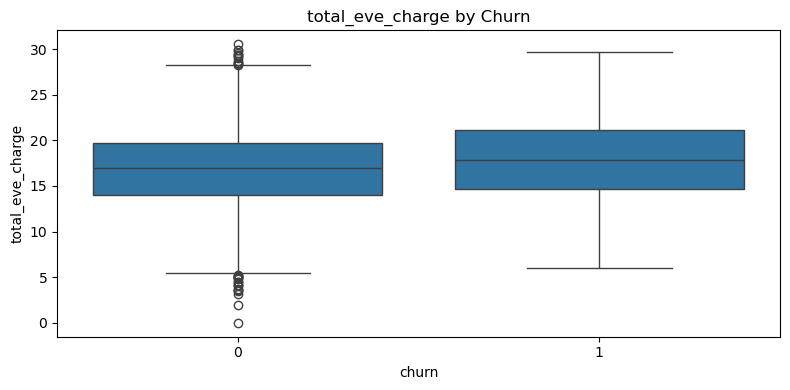

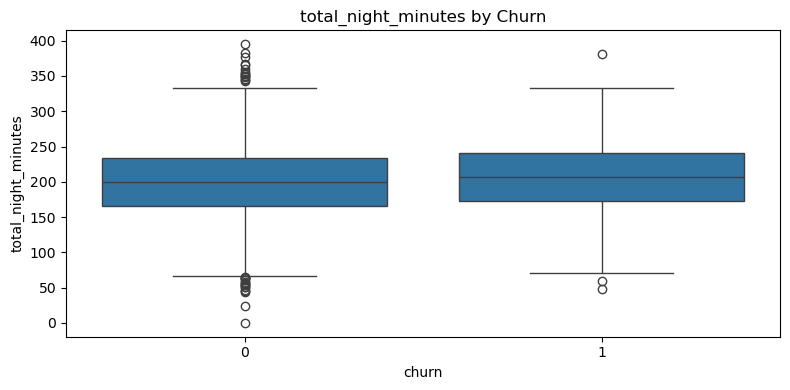

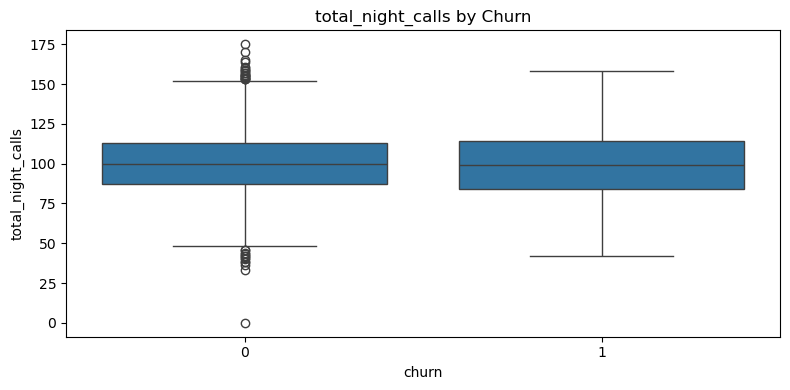

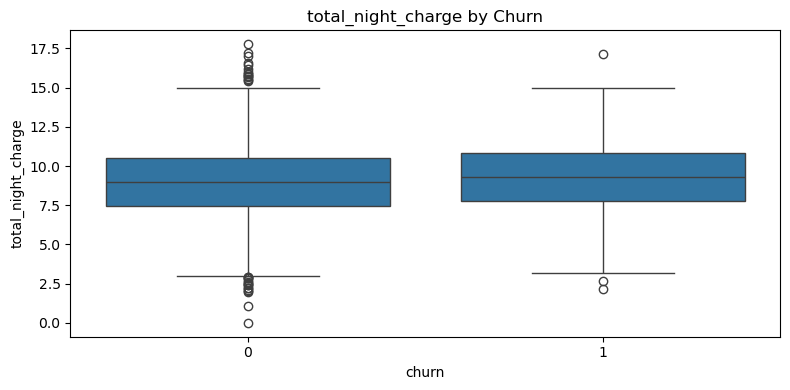

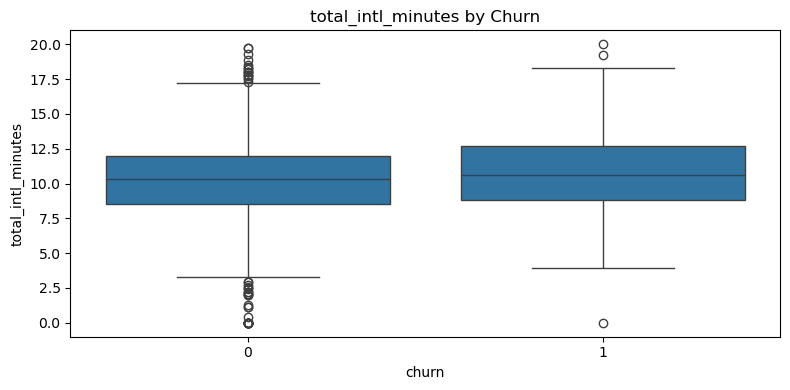

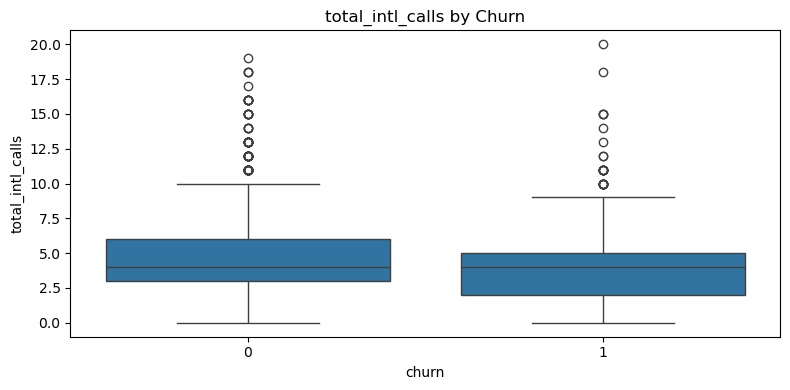

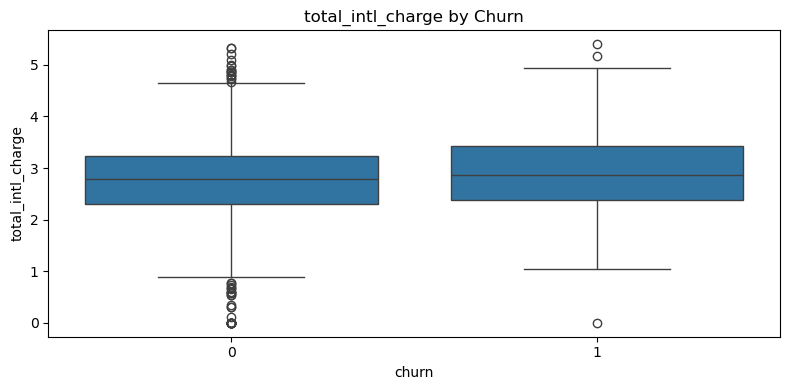

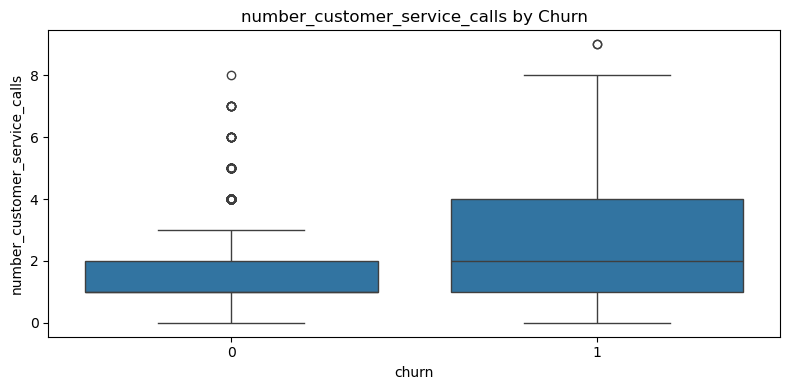

In [4]:

train['churn'] = train['churn'].map({'yes': 1, 'no': 0})  # Convert to binary

numerical_vars = [
    'account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 
    'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
    'total_night_minutes', 'total_night_calls', 'total_night_charge',
    'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
    'number_customer_service_calls'
]

for var in numerical_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='churn', y=var, data=train)
    plt.title(f'{var} by Churn')
    plt.tight_layout()
    plt.show()


In [5]:
# Example to compute IQR-based limits
# Only numerical columns
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('churn')  # Exclude target

outlier_limits = {}
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outlier_limits['lower_limit_' + col] = lower_limit
    outlier_limits['upper_limit_' + col] = upper_limit


In [6]:
for col in num_cols:
    train[col] = np.where(
        train[col] > outlier_limits['upper_limit_' + col],
        outlier_limits['upper_limit_' + col],
        np.where(
            train[col] < outlier_limits['lower_limit_' + col],
            outlier_limits['lower_limit_' + col],
            train[col]
        )
    )


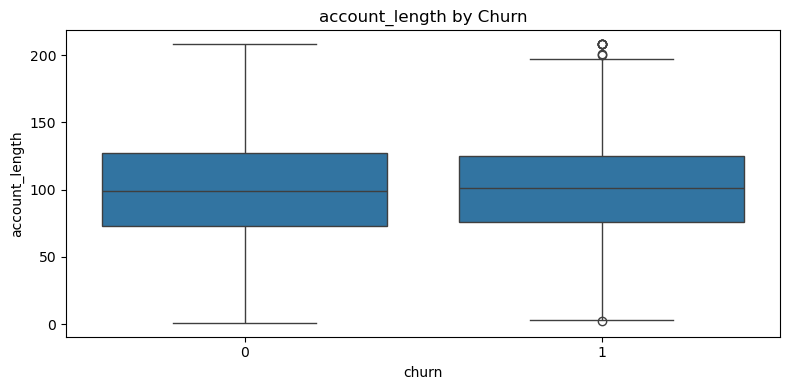

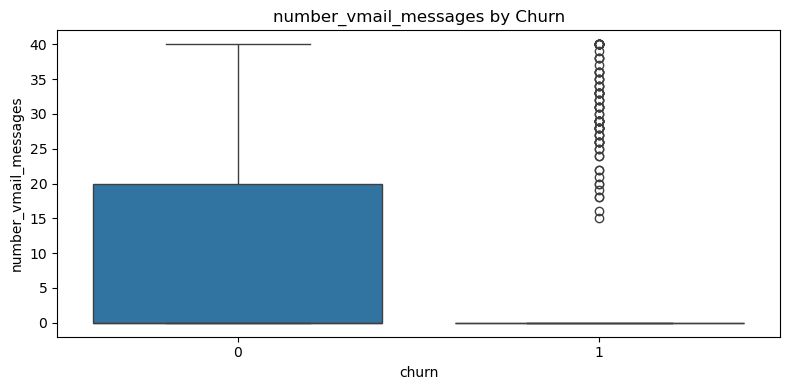

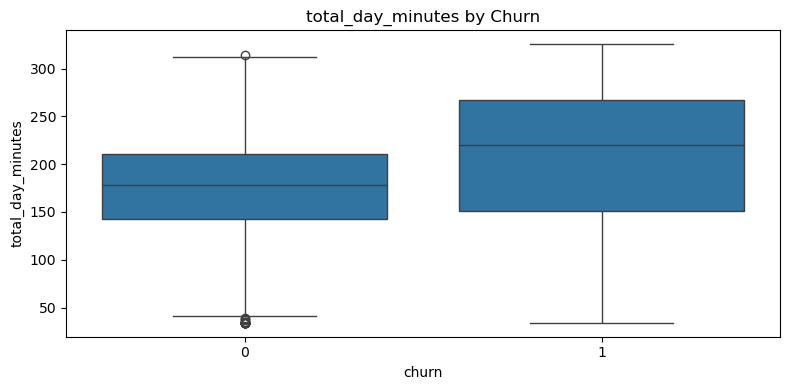

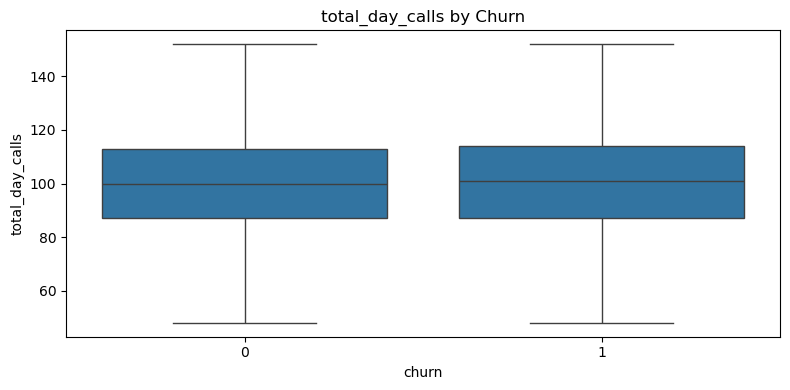

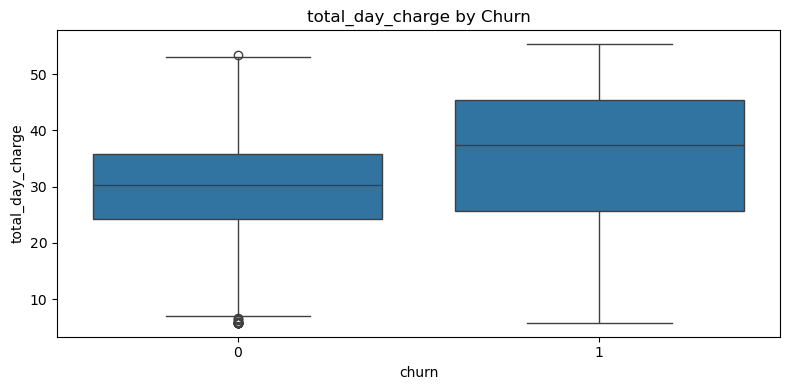

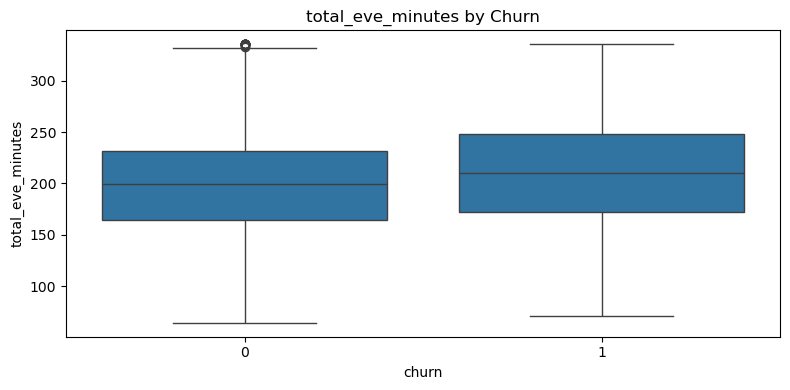

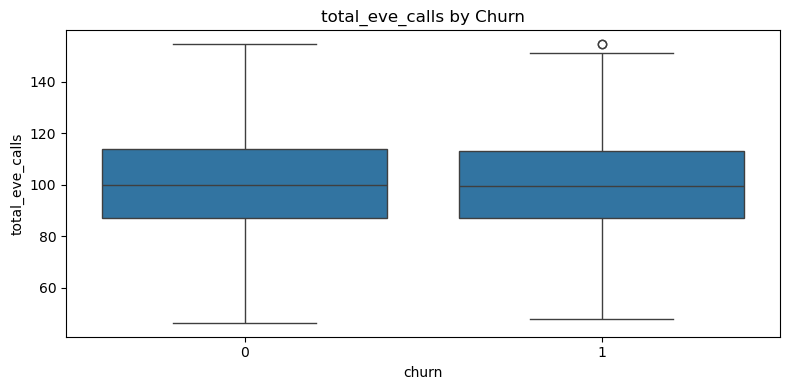

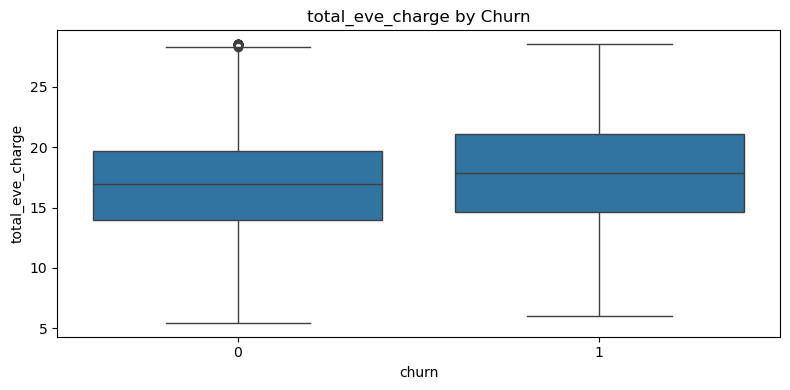

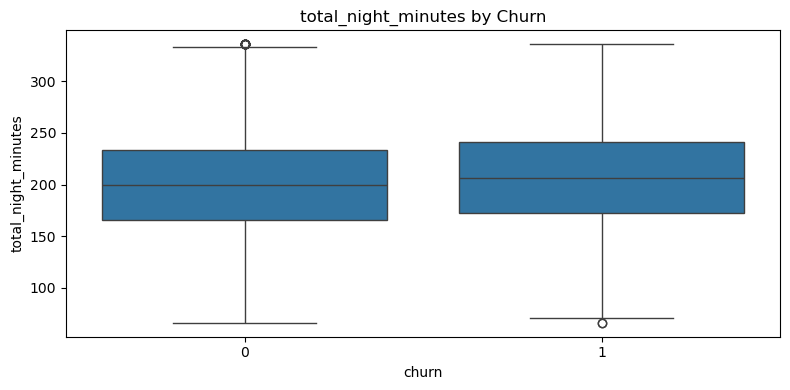

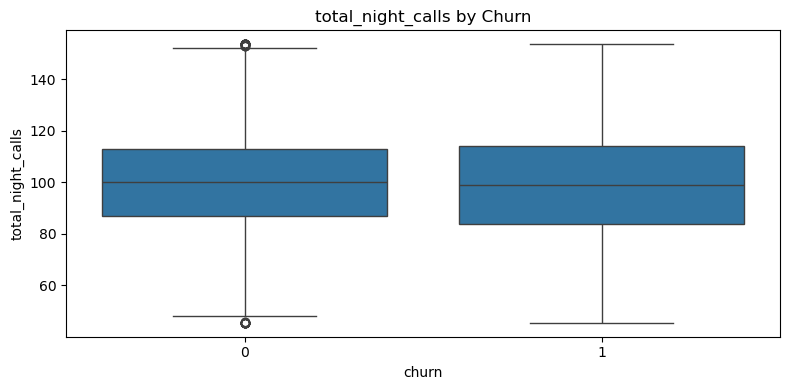

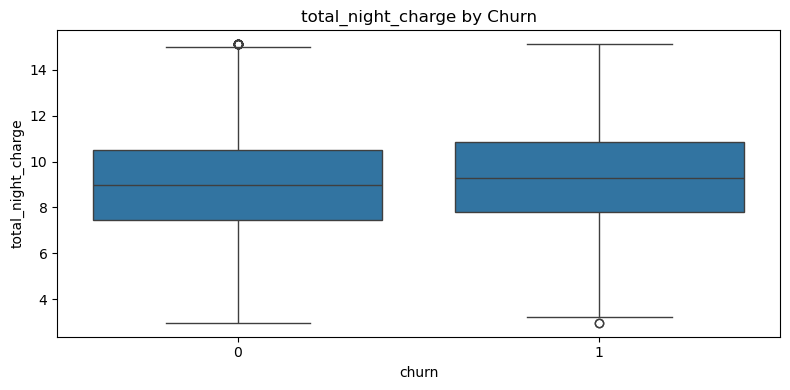

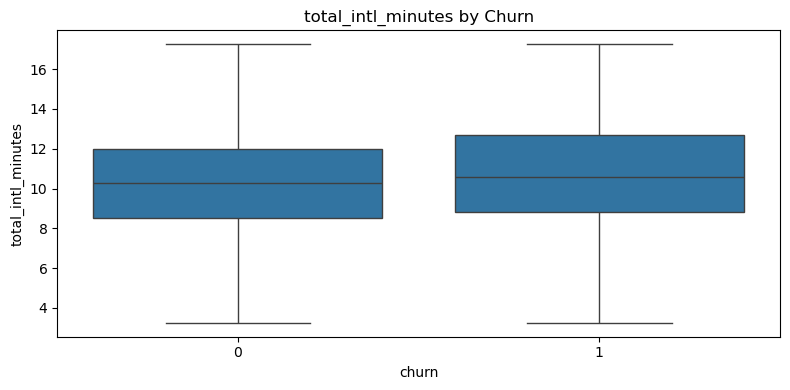

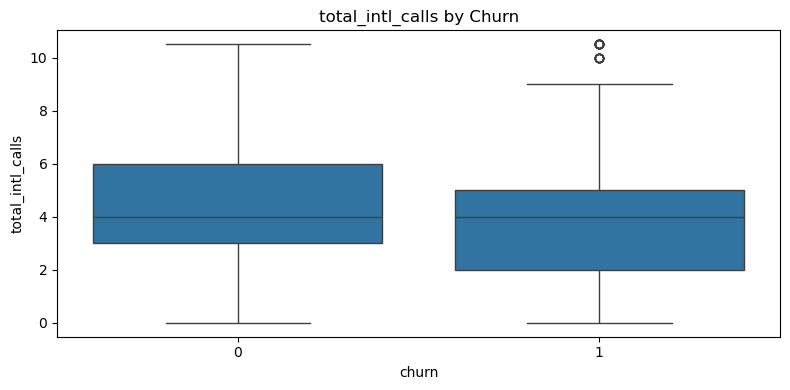

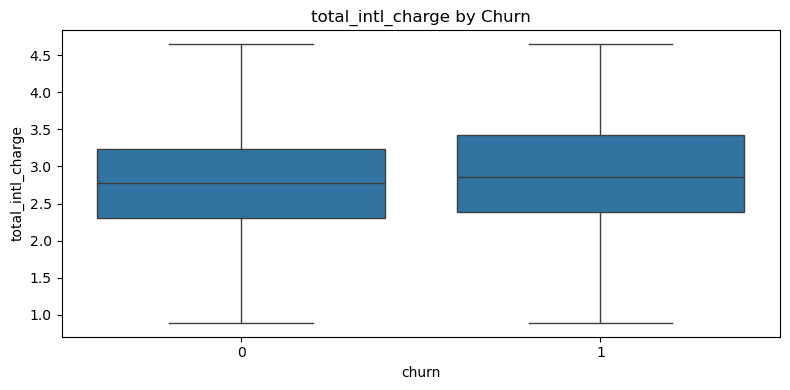

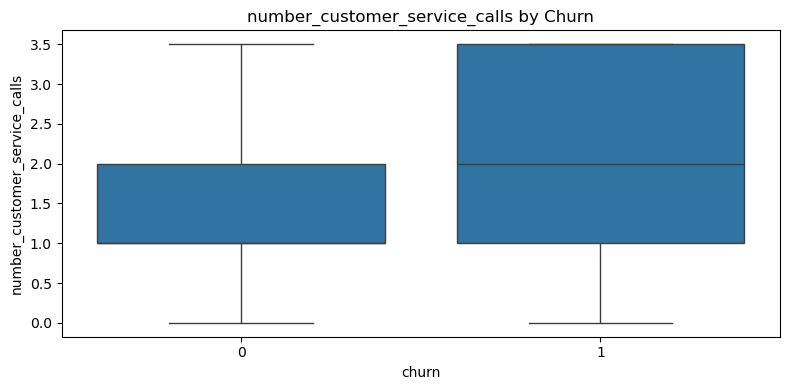

In [7]:

for var in numerical_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='churn', y=var, data=train)
    plt.title(f'{var} by Churn')
    plt.tight_layout()
    plt.show()


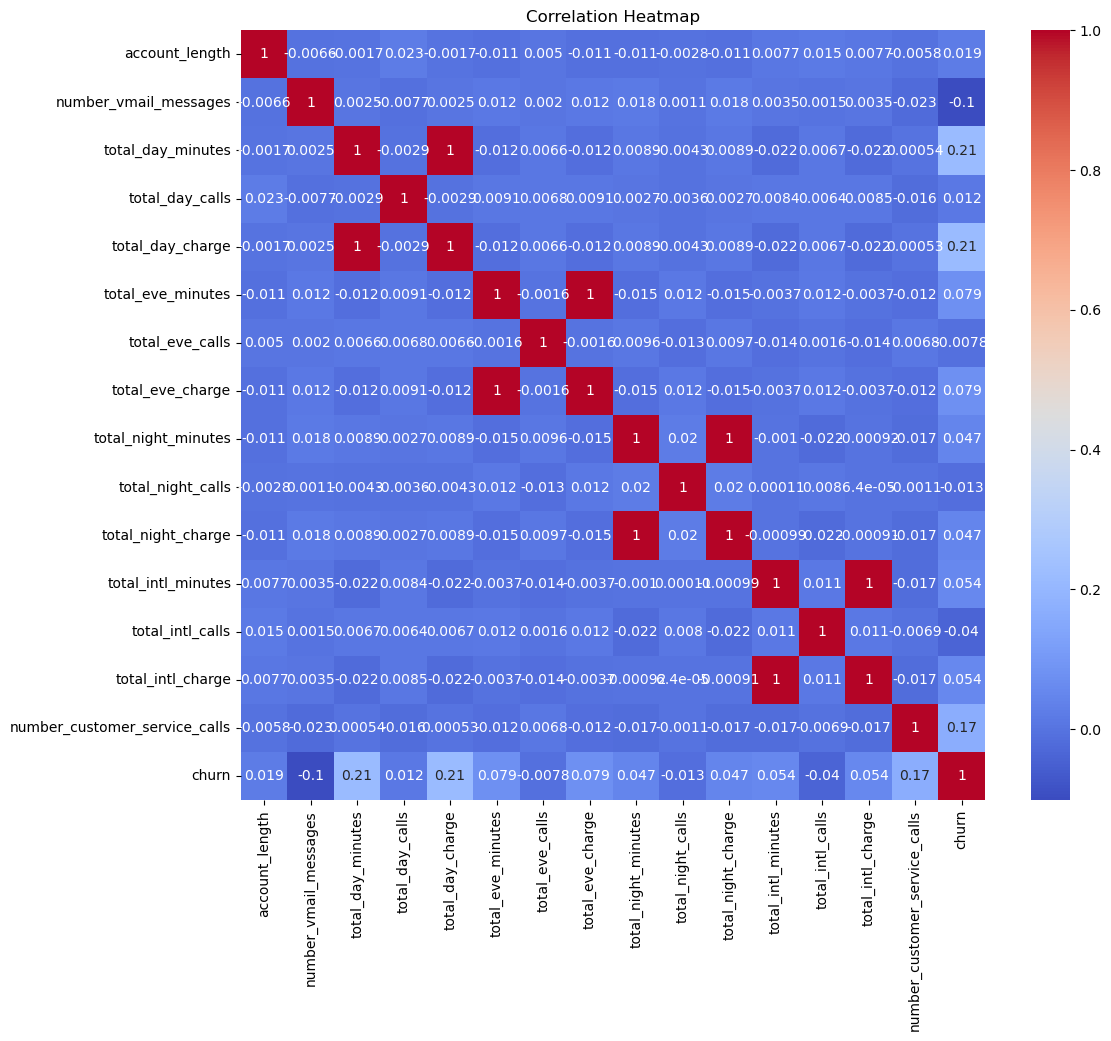

In [8]:

# Correlation with churn
corr = train.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [9]:
# Describe the string data
train.describe(include='O')

,state,area_code,international_plan,voice_mail_plan
count,4250,4250,4250,4250
unique,51,3,2,2
top,WV,area_code_415,no,no
freq,139,2108,3854,3138


In [10]:

train['international_plan'] = train['international_plan'].map({'yes': 1, 'no': 0}) 
train['voice_mail_plan'] = train['voice_mail_plan'].map({'yes': 1, 'no': 0}) 

test['international_plan'] = test['international_plan'].map({'yes': 1, 'no': 0})
test['voice_mail_plan'] = test['voice_mail_plan'].map({'yes': 1, 'no': 0}) 

id_submission = test.id
test = test.drop('id', axis=1)

In [11]:
onehot_area = OneHotEncoder()
categorical_features = ['state', 'area_code']

for i in categorical_features:
    onehot_area.fit(train[[i]])
    # Train
    encoded_values = onehot_area.transform(train[[i]])
    train[onehot_area.categories_[0]] = encoded_values.toarray()
    train = train.drop(i, axis=1)

    # Test
    encoded_values = onehot_area.transform(test[[i]])
    test[onehot_area.categories_[0]] = encoded_values.toarray()
    test = test.drop(i, axis=1)


In [12]:
# Prepare data for model
df = train.copy()
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

In [14]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.7, 
                        subsample=0.8, nthread=10, learning_rate=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.9576470588235294
Classification report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1102
           1       0.98      0.70      0.82       173

    accuracy                           0.96      1275
   macro avg       0.97      0.85      0.90      1275
weighted avg       0.96      0.96      0.95      1275

Confusion Matrix
[[1100    2]
 [  52  121]]
Cohen kappa score: 
0.7943806332538929


In [15]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.96
Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1102
           1       0.99      0.71      0.83       173

    accuracy                           0.96      1275
   macro avg       0.97      0.86      0.90      1275
weighted avg       0.96      0.96      0.96      1275

Confusion Matrix
[[1101    1]
 [  50  123]]
Cohen kappa score: 
0.8063412266098026
